### Imports

In [1]:
import os

import numpy as np

import mne
from mne.time_frequency import psd_welch

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

from matplotlib import pyplot as plt

import raw_data_loader as data_loader

In [2]:
edfs_path = "../../../dataverse_files"

## Load data

In [3]:
X, y = data_loader.load_data(edfs_path, segment_len=5.0, seed=1337)

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [185, 182, 182, 185, 189, 186, 182, 182, 181, 223, 183, 180, 193, 173, 169, 229, 192, 241, 178, 148, 269, 182, 237, 170, 272, 217, 227, 434]

negative:  3165
positive:  2606


### Feature Extraction (Variance)

In [4]:
np.set_printoptions(precision=50)

In [5]:
def variance_extraction(data):
    featuresVar = []
    for index, feature in enumerate(data.get_data()):
        featuresVar.append(np.var(feature, axis = 1))

    return np.array(featuresVar)



In [6]:
# X = np.array([[np.sqrt(np.var(channel_data)) for channel_data in epoch] for epoch in X])

In [7]:
X = variance_extraction(X)

In [8]:
from sklearn.preprocessing import MinMaxScaler

min_max_range = (0,1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

print(np.max(X))
print(np.min(X))

1.0000000000000002
0.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1337)

In [10]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (4616, 19)
y_train:  (4616,)
X_test:  (1155, 19)
y_test:  (1155,)


### Sklearn MLP Classifier

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


clf = MLPClassifier(random_state=1337, max_iter=300).fit(X_train, y_train)

F1 Score: 0.702247191011236
ACC: 0.5411255411255411


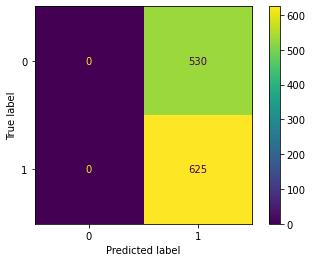

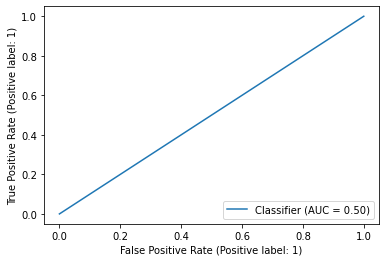

In [14]:
y_pred = clf.predict(X_test)
res_f1_score = f1_score(y_test, y_pred)
res_acc = clf.score(X_test, y_test)

print(f"F1 Score: {res_f1_score}")
print(f"ACC: {res_acc}")


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


RocCurveDisplay.from_predictions(y_test, y_pred)




In [15]:
train_loss_ = clf.loss_curve_

In [16]:
clf.predict_proba(X_test[:1])


array([[0.44381039557284596, 0.556189604427154  ]])

In [17]:
y_test_pred = clf.predict(X_test)


In [18]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[  0, 530],
       [  0, 625]], dtype=int64)

In [19]:
clf.score(X_test, y_test)


0.5411255411255411

In [20]:
clf.loss_curve_

[0.7018039274956135,
 0.6900720809967458,
 0.6883712525007712,
 0.6881337577745815,
 0.6881893362301871,
 0.6882567527668044,
 0.6881309879023952,
 0.6881715949292124,
 0.6882058935451814,
 0.6881817576000605,
 0.6881810186996166,
 0.68829177563419,
 0.6881194605306038,
 0.6881738021116197,
 0.6882484347344269]

In [21]:
# clf.loss_curve_
clf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

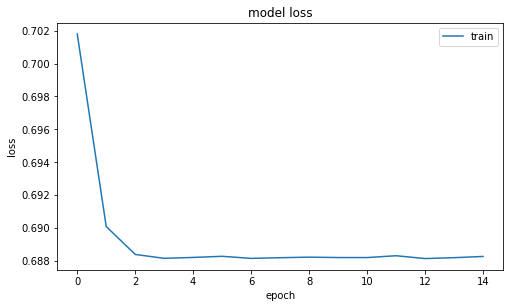

In [22]:
plt.figure(figsize=(8,10))

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(train_loss_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

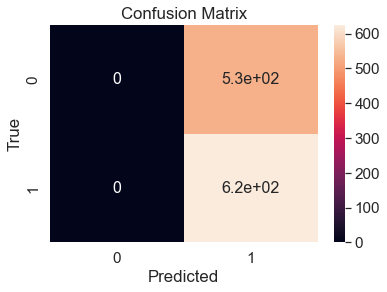

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}) # font size


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()